<a href="https://colab.research.google.com/github/hirotakaster/imagesearch/blob/main/IPCA_faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faiss/OpenCVのインストール
FaissはGPUを利用する。ランタイムの設定でGPUを有効にしておく。

In [1]:
!pip install faiss-gpu
!pip install opencv-python==4.4.0.46
!git clone https://github.com/hirotakaster/imagesearch

     |████████████████████████████████| 90.1 MB 20 kB/s 
     |████████████████████████████████| 49.5 MB 85 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Cloning into 'imagesearch'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 140 (delta 2), reused 132 (delta 0), pack-reused 0
Receiving objects: 100% (140/140), 32.24 MiB | 5.97 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Utility関係の関数 

In [2]:
# 画像表示用
from google.colab.patches import cv2_imshow
from sklearn.decomposition import IncrementalPCA
from PIL import Image
import matplotlib.pyplot as plt
import re
import cv2
import glob
import os
import numpy as np
import pickle

def show_image_files(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, f in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def img_to_matrix(img):
    img_array = np.asarray(img)
 
    return img_array
 
def flatten_img(img_array):
    s = img_array.shape[0] * img_array.shape[1] * img_array.shape[2]
    img_width = img_array.reshape(1, s)
 
    return img_width[0]


## 画像ファイルを読み込んでデータセットを用意する
search indexは読み込んだ画像の連番のindex。

In [3]:
IMG_SIZE = (500, 500)
# search index
idx = 49

files = sorted(glob.glob("imagesearch/data/train/*.jpeg"), key=natural_keys)
dataset = []
alldescriptors = []
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.resize(IMG_SIZE, Image.BICUBIC)
    img = img_to_matrix(img)
    img = flatten_img(img)
    dataset.append(img)
dataset = np.array(dataset)

## IPCAで次元削減を行う
ここで dim(次元数) を変える事で、次元数を任意に変更することも出来る。

In [4]:
n = dataset.shape[0]
batch_size = len(dataset)
dim = batch_size-1
ipca = IncrementalPCA(dim)
for i in range(n//batch_size):
    r_dataset = ipca.partial_fit(dataset[i*batch_size:(i+1)*batch_size])
r_dataset = ipca.transform(dataset)

## IPCAで次元削減された画像を表示

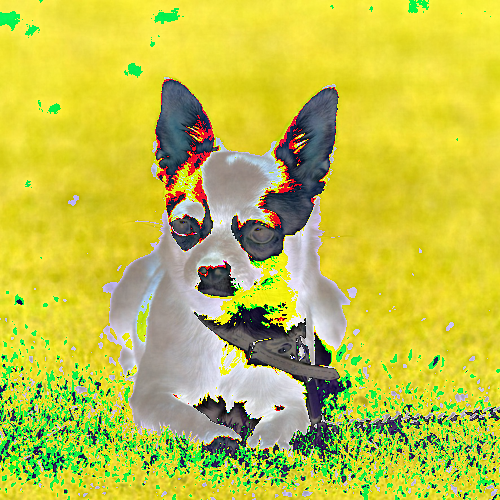

In [5]:
transformed = ipca.transform([dataset[idx]])
pilImg = Image.fromarray(255 - (transformed.dot(ipca.components_).reshape([500, 500, 3])).astype(np.uint8))
display(pilImg)

## 圧縮したデータセットを利用してFaiss Indexを生成する

In [6]:
import faiss

faissidx = faiss.IndexFlatL2(dim)
r2_dataset = r_dataset.astype(np.float32)
for d in r2_dataset:
  faissidx.add(d.reshape(-1, dim))


## 画像検索の実行

original image


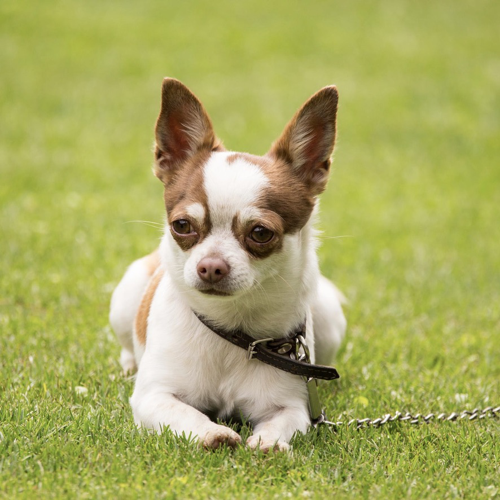

similar  image


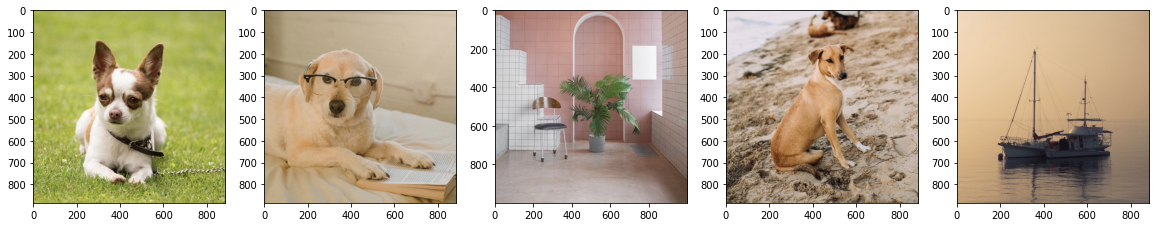

In [7]:
input_image = Image.open(files[idx])
print ("original image")
display(input_image.resize(IMG_SIZE))

print ("similar  image")
d, i = faissidx.search(r2_dataset[idx].reshape(-1, dim), 5)
hitfiles = map(lambda f: files[f], i[0][::])
show_image_files(list(hitfiles))